In [1]:
import numpy as np
import pandas as pd
from tqdm import tqdm
from astropy import wcs
from astropy.io import fits
import matplotlib.pyplot as plt

In [2]:
# Define path to data
data_path = '/Volumes/ES-HDD-Documents/Documents/matlas_dwarfs'

# Load fits sky as Numpy and Header
with fits.open(f'{data_path}/NGC4249.l.r.Mg004.fits') as hdul:
    
    primary_hdu = hdul[0]
    data = primary_hdu.data  # This is a NumPy array
    header = primary_hdu.header  # This is a FITS header object

# Load center position of Dwarfs in RA and DEC
df = pd.read_csv(f'{data_path}/MATLAS_dwarfs_Poulain2021.tsv', delimiter=';')
ra_dwarf, dec_dwarf, id_dwarfs, host = df['RAJ2000'].to_numpy(), df['DEJ2000'].to_numpy(), df['ID'].to_numpy(), df['HostETG'].to_numpy()
host_filter = host == 'NGC4259  '


In [3]:
# Get the pixel corners of the image
x_pixels, y_pixels = data.shape

# Get dwarfs coordinates in pixels
w = wcs.WCS(header)
dwarf_x_pixel, dwarf_y_pixel = np.round( w.wcs_world2pix(ra_dwarf, dec_dwarf, 0) ).astype(int)

/var/folders/bz/ftchh2fx1mzg7zrsqk32mjp40000gn/T/ipykernel_50596/2677044469.py:6: RuntimeWarning: invalid value encountered in cast
  dwarf_x_pixel, dwarf_y_pixel = np.round( w.wcs_world2pix(ra_dwarf, dec_dwarf, 0) ).astype(int)


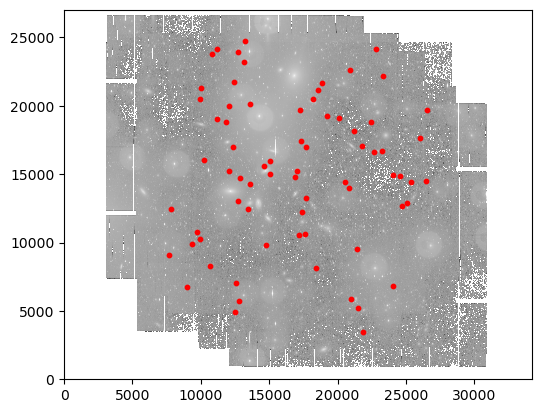

In [663]:
plt.imshow(data, origin='lower', cmap='gray', norm='log')
plt.scatter(dwarf_x_pixel[host_filter], dwarf_y_pixel[host_filter], c='r', s=10)

In [76]:
# Only take Dwarfs with good data

size = 128
n_patches = 122**2

dwarf_x_min, dwarf_x_max = x_pixels // 2 - size * np.sqrt(n_patches).astype(int)//2, x_pixels // 2 + size * np.sqrt(n_patches).astype(int)//2
dwarf_y_min, dwarf_y_max = y_pixels // 2 - size * np.sqrt(n_patches).astype(int)//2, y_pixels // 2 + size * np.sqrt(n_patches).astype(int)//2

dwarf_xlim_in = (dwarf_x_min <= dwarf_x_pixel) & (dwarf_x_pixel <= dwarf_x_max)
dwarf_ylim_in = (dwarf_y_min <= dwarf_y_pixel) & (dwarf_y_pixel <= dwarf_y_max)
dwarf_lim_in  = dwarf_xlim_in * dwarf_ylim_in

data_in = data[dwarf_y_min:dwarf_y_max, dwarf_x_min:dwarf_x_max] # Transpose to have the same orientation as the dwarfs (dunno why)
dwarf_x_pixel_in, dwarf_y_pixel_in = dwarf_x_pixel[dwarf_lim_in] - dwarf_x_min, dwarf_y_pixel[dwarf_lim_in] - dwarf_y_min
dwarf_id_in = id_dwarfs[dwarf_lim_in]

  0%|          | 0/45 [00:00<?, ?it/s]

 98%|█████████▊| 44/45 [00:00<00:00, 109.25it/s]


ValueError: num must be an integer with 1 <= num <= 44, not 45

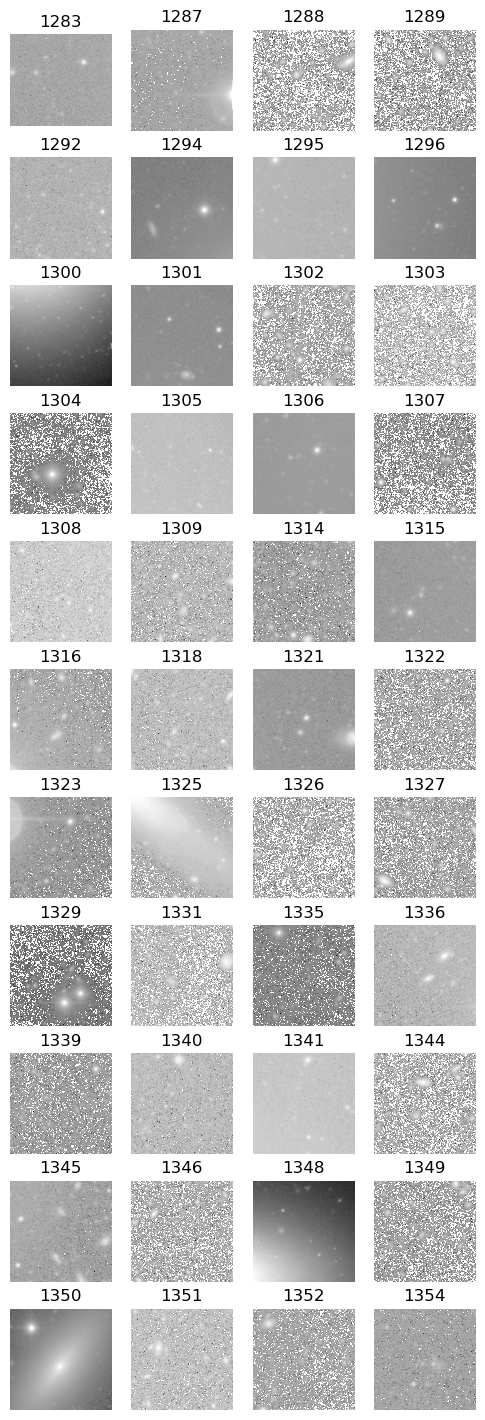

In [119]:
arg_test = np.random.choice(len(dwarf_x_pixel_in))

test_size = 128
plt.figure(figsize=(6,18))
for i in tqdm(range(len(dwarf_x_pixel_in))):
    plt.subplot(11,4,i+1)
    plt.title(f"{dwarf_id_in[i].split('-')[-1]}")
    x_dwarf_test, y_dwarf_test = dwarf_x_pixel_in[i], dwarf_y_pixel_in[i]
    plt.imshow(data_in[x_dwarf_test-test_size:x_dwarf_test+test_size, y_dwarf_test-test_size:y_dwarf_test+test_size], origin='lower', cmap='gray', norm='log')
    plt.axis('off')

In [77]:
dwarf_map = np.zeros_like(data_in)
dwarf_map[dwarf_x_pixel_in, dwarf_y_pixel_in] = 1

In [78]:
data_patch = np.zeros((n_patches, 1, size, size))
dwarf_patch = np.zeros((n_patches, 1, size, size))

for i in tqdm(range(n_patches)):
    x, y = np.unravel_index(i, (np.sqrt(n_patches).astype(int),np.sqrt(n_patches).astype(int)))
    data_patch[i,0,:,:] = data_in[x*size:(x+1)*size, y*size:(y+1)*size]
    dwarf_patch[i,0,:,:] = dwarf_map[x*size:(x+1)*size, y*size:(y+1)*size]

100%|██████████| 14884/14884 [00:09<00:00, 1568.44it/s]


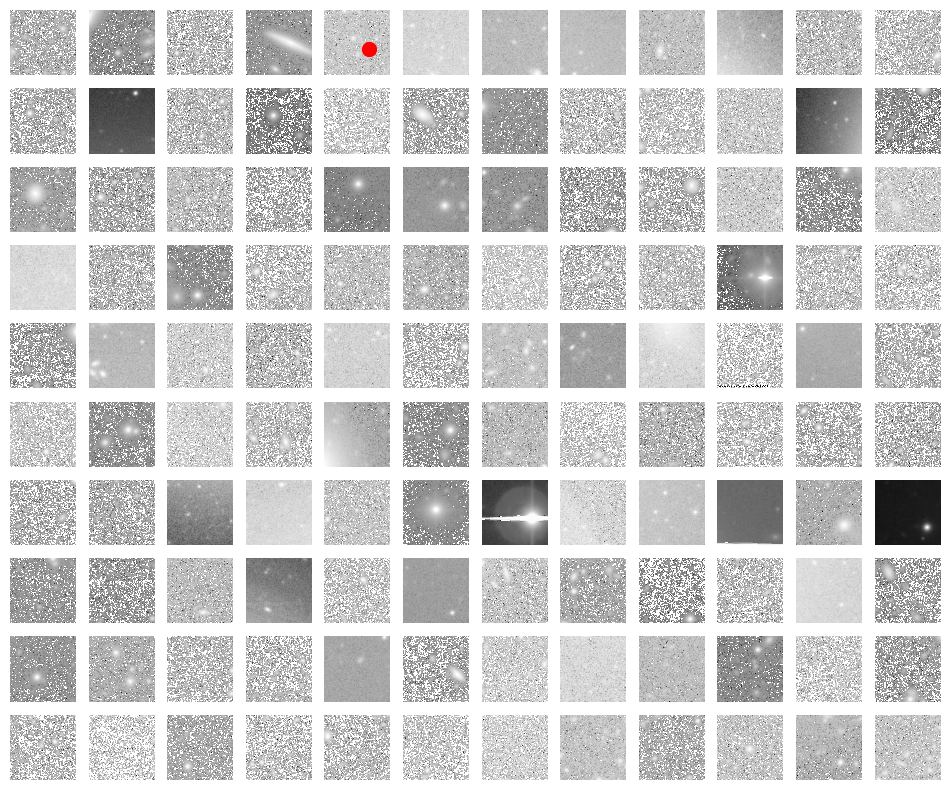

In [115]:
amount = 120
idx = np.random.randint(0, n_patches, amount)


plt.figure(figsize=(12,10))

for i in range(amount):
    plt.subplot(10,12,i+1)
    plt.imshow(data_patch[idx[i],0,:,:].T, origin='lower', cmap='gray', norm='log')
    dwarf_here = np.where( dwarf_patch[idx[i],0,:,:] != 0)
    plt.scatter(dwarf_here[0], dwarf_here[1], c='r', s=100)
    plt.axis('off')

# plt.ylim(175,225)
# plt.xlim(100,150)

(-0.5, 127.5, -0.5, 127.5)

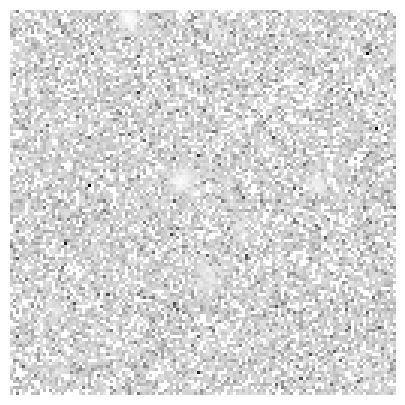

In [118]:
plt.figure(figsize=(10,5))
here = 4
plt.imshow(data_patch[idx[here],0,:,:].T, origin='lower', cmap='gray', norm='log')
dwarf_here = np.where( dwarf_patch[idx[here],0,:,:] != 0)
# plt.scatter(dwarf_here[0], dwarf_here [1], c='r')#, s=10)
plt.axis('off')

In [154]:
idx % 122

60

11

In [281]:
all_x_init = np.arange(0, x_pixels, size)
all_y_init = np.arange(0, y_pixels, size)

data_patch = np.zeros( ((len(all_x_init)-1)*(len(all_y_init-1)),1, size, size) )
dwarf_patch = np.zeros( data_patch.shape)

idx = 0
for index, i in enumerate(all_x_init):
    for jndex, j in enumerate(all_y_init):
        if jndex<len(all_y_init)-1 and index<len(all_x_init)-1:
            data_patch[idx] = data[i:all_x_init[index+1], j:all_y_init[jndex+1]]
            dwarf_patch[idx] = dwarf_map[i:all_x_init[index+1], j:all_y_init[jndex+1]]
            idx += 1

keep_patch = np.sum( data_patch, axis=(1,2,3) ) != 0
data_save  = data_patch[keep_patch]
dwarf_save = dwarf_patch[keep_patch]

In [290]:
np.where( np.sum( dwarf_patch, axis=(1,2,3) ) != 0)[0].shape

(69,)

In [295]:
np.argmax( np.sum( dwarf_patch, axis=(1,2,3) ) )

12878

In [299]:
data_patch[12878,0]

array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]])

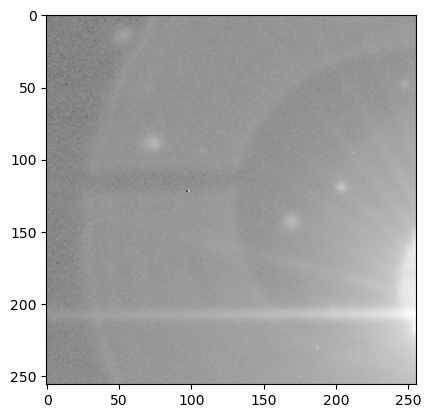

In [279]:
plt.imshow(np.arcsinh( data_save[-103,0]), cmap='gray' )

In [242]:
segmentation_patches.shape

torch.Size([105, 1, 1, 256, 34260])

In [228]:
# Get random patch of 256x256 pixels
size = 256
batch_size = 4
x_init = np.random.randint(size, x_pixels - size, batch_size)
y_init = np.random.randint(size, y_pixels - size, batch_size)

a = np.sign(np.random.uniform(-1, 1))
b = np.sign(np.random.uniform(-1, 1))

if a == 1:
    x_start = x_init
    x_end = x_init + size
else:
    x_start = x_init - size
    x_end = x_init

if b == 1:
    y_start = y_init
    y_end = y_init + size
else:
    y_start = y_init - size
    y_end = y_init

x_in = (x_start[:, None] <= dwarf_x_pixel[None, :]) & (dwarf_x_pixel[None, :] <= x_end[:, None])
y_in = (y_start[:, None] <= dwarf_y_pixel[None, :]) & (dwarf_y_pixel[None, :] <= y_end[:, None])
in_in = x_in * y_in

input = data[x_start:x_end, y_start:y_end]
label = np.zeros((size, size))
if x_in.sum() != 0:
    label[dwarf_x_pixel[in_in] - x_start, dwarf_y_pixel[in_in] - y_start] = 1

# plt.figure(figsize=(15, 10))
# plt.subplot(1,2,1)
# if input.max() == 0:
#     plt.imshow(input, cmap='gray')
# else:
#     plt.imshow(input, cmap='gray', norm='log')
# plt.axis('off')
# plt.subplot(1,2,2)
# plt.imshow(label, cmap='gray')
# plt.title(f'{label.sum()}')
# plt.axis('off');

TypeError: only integer scalar arrays can be converted to a scalar index

In [182]:
len(dwarf_in) / x_pixels * y_pixels

88.71051268772658